In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

assert torch.cuda.is_available()
print(pd.__version__)

1.4.3


In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

True


In [3]:
plt.rcParams['figure.figsize'] = (15.0, 8.0)

In [4]:
from operator import index


sensor_data = pd.read_csv('sensor.csv', parse_dates=['timestamp'], index_col='timestamp')
display(sensor_data.info())
display(sensor_data.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 220320 entries, 2018-04-01 00:00:00 to 2018-08-31 23:59:00
Data columns (total 54 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   sensor_00       210112 non-null  float64
 2   sensor_01       219951 non-null  float64
 3   sensor_02       220301 non-null  float64
 4   sensor_03       220301 non-null  float64
 5   sensor_04       220301 non-null  float64
 6   sensor_05       220301 non-null  float64
 7   sensor_06       215522 non-null  float64
 8   sensor_07       214869 non-null  float64
 9   sensor_08       215213 non-null  float64
 10  sensor_09       215725 non-null  float64
 11  sensor_10       220301 non-null  float64
 12  sensor_11       220301 non-null  float64
 13  sensor_12       220301 non-null  float64
 14  sensor_13       220301 non-null  float64
 15  sensor_14       220299 non-null  float64
 16  sensor_15       0 non-

None

,Unnamed: 0,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,0,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2018-04-01 00:01:00,1,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2018-04-01 00:02:00,2,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
2018-04-01 00:03:00,3,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
2018-04-01 00:04:00,4,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [5]:
sensor_data.drop(['Unnamed: 0'], axis=1, inplace=True)
sensor_data.dropna(axis=1, thresh=15000, inplace=True)
sensor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 220320 entries, 2018-04-01 00:00:00 to 2018-08-31 23:59:00
Data columns (total 52 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   sensor_00       210112 non-null  float64
 1   sensor_01       219951 non-null  float64
 2   sensor_02       220301 non-null  float64
 3   sensor_03       220301 non-null  float64
 4   sensor_04       220301 non-null  float64
 5   sensor_05       220301 non-null  float64
 6   sensor_06       215522 non-null  float64
 7   sensor_07       214869 non-null  float64
 8   sensor_08       215213 non-null  float64
 9   sensor_09       215725 non-null  float64
 10  sensor_10       220301 non-null  float64
 11  sensor_11       220301 non-null  float64
 12  sensor_12       220301 non-null  float64
 13  sensor_13       220301 non-null  float64
 14  sensor_14       220299 non-null  float64
 15  sensor_16       220289 non-null  float64
 16  sensor_17       220274

In [6]:
conditions = [(sensor_data['machine_status'] =='NORMAL'), (sensor_data['machine_status'] =='BROKEN'), (sensor_data['machine_status'] =='RECOVERING')]
choices = [1, 0, 0]
sensor_data['Operation'] = np.select(conditions, choices, default=0)
df0 = pd.DataFrame(sensor_data, columns=['Operation','sensor_04', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09']).dropna()
df0.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 214251 entries, 2018-04-01 00:00:00 to 2018-08-31 23:59:00
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Operation  214251 non-null  int64  
 1   sensor_04  214251 non-null  float64
 2   sensor_06  214251 non-null  float64
 3   sensor_07  214251 non-null  float64
 4   sensor_08  214251 non-null  float64
 5   sensor_09  214251 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 11.4 MB


In [7]:
df0.values[:, 1:].astype(np.float32).transpose().shape

(5, 214251)

In [8]:
df0.shape

(214251, 6)

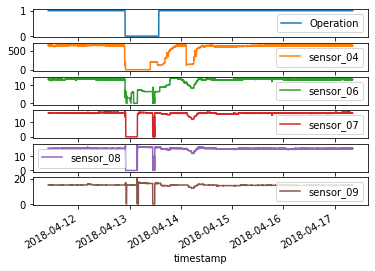

In [9]:
df0.iloc[15000:23500].plot(subplots=True)
plt.show()

In [10]:
class SensorDataset(torch.utils.data.Dataset):
    def __init__(self, values: np.array) -> None:
        super().__init__()
        self.n_samples = len(values)
        self.unlabeled_mask = np.ones(self.n_samples)
        self.unlabeled_mask[18000: 22000] = 0
        self.x_data = torch.from_numpy(values[:, 1:].astype(np.float32))
        self.y_data = torch.from_numpy(values[:, 0].astype(np.float32)).view(-1, 1)
    
    def __getitem__(self, index: int) -> torch.Tensor:
        return self.x_data[index], self.y_data[index], index
    
    def __len__(self) -> int:
        return self.n_samples


train_data, test_data = df0.values[:107125], df0.values[107125:]
train_dataset = SensorDataset(train_data)
test_dataset = SensorDataset(test_data)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=128,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=128,
    shuffle=False
)

dataloaders = {
    'train': train_loader,
    'eval': test_loader
}

dataset_sizes = {
    'train': len(train_dataset),
    'eval': len(test_dataset)
}

In [12]:
class ConvNet(nn.Module):
    def __init__(self) -> None:
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv1d(5, 16, 100)  # L_out = 1075 + 2 * 1 - 1 * (100 - 1) = 978
        self.pool1 = nn.MaxPool1d(3)  # L_out = 978 + 2 - 99 = 881
        self.conv2 = nn.Conv1d(16, 32, 100)  # L_out = 881  + 2 - 99 = 784
        self.pool2 = nn.MaxPool1d(3)  # L_out = 784 + 3 - 100 = 687
        self.fc1 = nn.Linear(32*44, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        # print("Conv1 shape output", out.shape)
        out = self.pool1(out)
        # print('Pool1 shape output:', out.shape)
        
        out = self.conv2(out)
        out = F.relu(out)
        # print("Conv2 shape output", out.shape)
        out = self.pool2(out)
        # print('Pool2 shape output:', out.shape)

        out = out.view(-1, 32*44)

        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = torch.sigmoid(self.fc3(out))

        return out


class LstmNet(nn.Module):
    def __init__(self, n_features: int) -> None:
        super(LstmNet, self).__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=100,
            batch_first=True,
        )
        self.pool = nn.MaxPool1d(10)
        self.fc = nn.Linear(10, 1)
    
    def forward(self, x):
        # print(f'{x.shape=}')
        out, _ = self.lstm(x)
        # print(f'{out.shape}')
        out = self.pool(out)
        # print(f'{out.shape=}')
        # out = out.view(-1, 128*50)
        # print(f'{out.shape}')
        out = self.fc(out)
        out = torch.sigmoid(out)
        return out

In [13]:
from sklearn.metrics import f1_score

num_epochs = 5

model = LstmNet(5).to(device)

def train(model, num_epochs, data_loaders: dict[str, DataLoader]):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.3)

    losses, accuracies = [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'eval']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            running_tp, running_fn, running_fp, running_tn = 0, 0, 0, 0

            # Iterate over data.
            for inputs, labels, _ in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = torch.where(outputs < 0.25, 0, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_tp += torch.sum(torch.logical_and(preds == 0, labels.data == 0))
                running_fn += torch.sum(torch.logical_and(preds == 1, labels.data == 0))
                running_fp += torch.sum(torch.logical_and(preds == 0, labels.data == 1))
                running_tn += torch.sum(torch.logical_and(preds == 0, labels.data == 0))

            if phase == 'train':
                scheduler.step()
            
            total_data = (data_loaders[phase].dataset.unlabeled_mask == 0).sum()

            epoch_loss = running_loss / total_data
            epoch_tpr = running_tp.double() / (running_tp + running_fn)
            epoch_tnr = running_tn.double() / (running_tn + running_fp)
            epoch_acc = (epoch_tpr.double() + epoch_tnr.double()) / 2
            epoch_recall = running_tp.double() / (running_tp + running_fn)
            epoch_precision = running_tp.double() / (running_tp + running_fp)
            
            losses.append(epoch_loss)
            accuracies.append(epoch_acc.cpu().item())

            print('{} Loss: {:.4f} Acc: {:.4f} Recall: {:.2f} Precision: {:.2f}'.format(
                phase, epoch_loss, epoch_acc, epoch_recall, epoch_precision))

            
    # fig, ax1 = plt.subplots()
    # ax1.set_xlabel('# epochs')
    # ax1.set_ylabel('Loss', color='orange')
    # ax1.plot(losses, color='orange', label='Loss')

    # ax2 = ax1.twinx()
    # ax2.set_ylabel('Accuracy', color='blue')
    # ax2.plot(accuracies, color='blue', label='Accuracy')
    # plt.show()

# train(model, num_epochs, dataloaders)

In [ ]:
example_inputs = [test_dataset[i][0].view(1, 5) for i in range(19500, 19600)]
example_inputs = torch.concat(example_inputs, dim=0)
example_inputs.shape

In [ ]:
with torch.no_grad():
    example_pred = model(example_inputs.to(device))


In [ ]:
# example_pred 24000DE

In [ ]:
# torch.concat([test_dataset[i][1].view(-1, 1) for i in range(19500, 19600)], dim=0)

In [ ]:
with torch.no_grad():
    test_preds = model(torch.Tensor(test_data[:, 1:]).to(device))

plt.plot(test_data[:,0], marker='.', label='True Label')
plt.plot(test_preds.cpu(), 'r', label='Prediction')
plt.legend()
plt.show()

In [20]:
class AbstractQuery:
    def __init__(self, model, query_size=10):
        self.model = model
        self.query_size = query_size
    
    def query(self, data_loader):
        pass

    
class RandomQuery(AbstractQuery):
    def __init__(self, model, query_size=10):
        super().__init__(model, query_size)
    
    def query(self, data_loader):
        sample_idx = []
        for batch in data_loader:
            _, _, idx = batch
            sample_idx.extend(idx.to_list())
            
            if len(sample_idx) >= self.query_size:
                break

        return sample_idx[:self.query_size]


class LeastConfidenceQuery(AbstractQuery):
    def __init__(self, model, query_size=10):
        super().__init__(model, query_size)
    
    def query(self, data_loader):
        confidences, indices = [], []
        
        model.eval()
        
        with torch.no_grad():
            for data, _, idx in data_loader:
                probabilities = self.model(data.to(device))
                confidences.extend(probabilities.cpu().tolist())
                indices.extend(idx.tolist())
        
        conf = np.asarray(confidences).reshape(len(confidences))
        ind = np.asarray(indices)
        sorted_pool = np.argsort(np.abs(0.5 - conf))
        return ind[sorted_pool][:self.query_size]


In [21]:
from torch.utils.data import SubsetRandomSampler

class Oracle:
    def __init__(self, model, dataset: SensorDataset, strategy='random', query_size=10, batch_size=128):
        self.dataset = dataset
        self.batch_size = batch_size
        if strategy == 'random':
            self.query_cls = RandomQuery(model, query_size)
        else:
            self.query_cls = LeastConfidenceQuery(model, query_size)
    
    def request_label(self):
        mask_unlabeled = np.where(self.dataset.unlabeled_mask == 1)[0]
        data_loader = DataLoader(
            dataset=self.dataset, 
            batch_size=self.batch_size,
            sampler=SubsetRandomSampler(mask_unlabeled)
        )
        new_labeled_idx = self.query_cls.query(data_loader)
        self.dataset.unlabeled_mask[new_labeled_idx] = 0
        mask_labeled = np.where(self.dataset.unlabeled_mask == 0)[0]
        return DataLoader(
            dataset=self.dataset,
            batch_size=self.batch_size,
            sampler=SubsetRandomSampler(mask_labeled)
        )

In [23]:
import traceback

num_queries = 3

train_dataset_al = SensorDataset(df0.values[:110000])
test_dataset_al = SensorDataset(df0.values[110000:])
test_dataloader_al = DataLoader(test_dataset_al, batch_size=128)
lstm_model = LstmNet(5).to(device)

first_phase_loaders = {
    'train': DataLoader(train_dataset_al, batch_size=128, sampler=SubsetRandomSampler(np.where(train_dataset_al.unlabeled_mask == 0)[0])),
    'eval': test_dataloader_al
}

train(lstm_model, 10, first_phase_loaders)

oracle = Oracle(
    model=lstm_model,
    dataset=train_dataset,
    strategy='lconf',
    batch_size=128
)
try:
    for query_i in range(10):
        print('Labeled data size:', (train_dataset.unlabeled_mask == 0).sum())
        next_data_loader = oracle.request_label()
        phase_loaders = {
            'train': next_data_loader,
            'eval': test_dataloader_al
        }
        train(model=lstm_model, num_epochs=10, data_loaders=phase_loaders)
except Exception as e:
    traceback.print_exc()
    print(e)

Epoch 0/9
----------
train Loss: 0.6653 Acc: nan Recall: 0.00 Precision: nan
eval Loss: 13.3899 Acc: nan Recall: 0.00 Precision: nan
Epoch 1/9
----------
train Loss: 0.4362 Acc: nan Recall: 0.00 Precision: nan
eval Loss: 9.3975 Acc: nan Recall: 0.00 Precision: nan
Epoch 2/9
----------
train Loss: 0.3185 Acc: nan Recall: 0.00 Precision: nan
eval Loss: 8.2448 Acc: nan Recall: 0.00 Precision: nan
Epoch 3/9
----------
train Loss: 0.2595 Acc: nan Recall: 0.00 Precision: nan
eval Loss: 6.5682 Acc: nan Recall: 0.00 Precision: nan
Epoch 4/9
----------
train Loss: 0.2187 Acc: nan Recall: 0.00 Precision: nan
eval Loss: 6.1328 Acc: nan Recall: 0.00 Precision: nan
Epoch 5/9
----------
train Loss: 0.2012 Acc: nan Recall: 0.00 Precision: nan
eval Loss: 5.7524 Acc: nan Recall: 0.00 Precision: nan
Epoch 6/9
----------
train Loss: 0.1857 Acc: nan Recall: 0.00 Precision: nan
eval Loss: 5.4304 Acc: nan Recall: 0.00 Precision: nan
Epoch 7/9
----------
train Loss: 0.1724 Acc: nan Recall: 0.00 Precision: na

In [53]:
arr = np.ones(4)
arr[1] = 0
np.where(arr == 0)

(array([1]),)